In [ ]:
!git clone https://github.com/spectre900/People-Identification-using-Face-and-Gait.git

Cloning into 'People-Identification-using-Face-and-Gait'...
remote: Enumerating objects: 96, done.
remote: Total 96 (delta 0), reused 0 (delta 0), pack-reused 96
Receiving objects: 100% (96/96), 264.61 MiB | 29.43 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (48/48), done.


In [ ]:
import os
import zipfile
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
from tensorflow.keras import layers, models, optimizers
from sklearn.utils import shuffle

In [ ]:
from google.colab.patches import cv2_imshow

Pre-Processing

In [ ]:
if not os.path.isdir('dataset'):
  os.system(' '.join(['cp', '-r', '/content/People-Identification-using-Face-and-Gait/dataset', 'dataset']))

In [ ]:
if not os.path.isdir('extracted_dataset'):
  os.system(' '.join(['mkdir', 'extracted_dataset']))
  files = os.listdir('dataset')
  for file in files:
      os.system(' '.join(['unzip' ,'dataset/' + file, '-d', 'extracted_dataset']))

In [ ]:
people = 40
timesteps = 32

for i in range(people):
    folder = 'extracted_dataset' + '/' + 'person' + str(i+1) + '/' + 'gait'
    styles = os.listdir(folder)
    styles.sort()
    for style in styles:
        folder2 = folder + '/' + style
        angles = os.listdir(folder2)
        angles.sort()
        for angle in angles:
            folder3 = folder2 + '/' + angle
            files = os.listdir(folder3)
            counter = 0
            while len(os.listdir(folder3)) < timesteps:
                counter += 1
                for file in files:
                    os.system(' '.join(['cp', folder3 + '/' + file, folder3 + '/' + file + '.' + str(counter)]))
            files = os.listdir(folder3)
            random.shuffle(files)
            files = files[timesteps:]
            for file in files:
                path = folder3 + '/' + file
                os.system(' '.join(['rm', '-rf', path]))
            files = os.listdir(folder3)
            files.sort()
            for k in range(timesteps):
                newFile = str(k+1)
                while len(newFile)<2:
                    newFile = '0' + newFile
                if (folder3 + '/' + files[k]) != (folder3 + '/' + newFile + '.png'):
                    os.system(' '.join(['mv', folder3 + '/' + files[k], folder3 + '/' + newFile + '.png']))
            print('person', str(i+1), '\tstyle', style, '\tangle', angle, '\t...done')

person 1 	style bg-01 	angle 000 	...done
person 1 	style bg-01 	angle 018 	...done
person 1 	style bg-01 	angle 036 	...done
person 1 	style bg-01 	angle 054 	...done
person 1 	style bg-01 	angle 072 	...done
person 1 	style bg-01 	angle 090 	...done
person 1 	style bg-01 	angle 108 	...done
person 1 	style bg-01 	angle 126 	...done
person 1 	style bg-01 	angle 144 	...done
person 1 	style bg-01 	angle 162 	...done
person 1 	style bg-01 	angle 180 	...done
person 1 	style bg-02 	angle 000 	...done
person 1 	style bg-02 	angle 018 	...done
person 1 	style bg-02 	angle 036 	...done
person 1 	style bg-02 	angle 054 	...done
person 1 	style bg-02 	angle 072 	...done
person 1 	style bg-02 	angle 090 	...done
person 1 	style bg-02 	angle 108 	...done
person 1 	style bg-02 	angle 126 	...done
person 1 	style bg-02 	angle 144 	...done
person 1 	style bg-02 	angle 162 	...done
person 1 	style bg-02 	angle 180 	...done
person 1 	style cl-01 	angle 000 	...done
person 1 	style cl-01 	angle 018 	

In [ ]:
if not os.path.isdir('processed_dataset'):
  os.system(' '.join(['mv', 'extracted_dataset', 'processed_dataset']))

In [ ]:
print('Total distinct people:', len(os.listdir('processed_dataset')))

Total distinct people: 40


Gait Energy Images of a person from 90: normal, holding a bag, wearing a coat



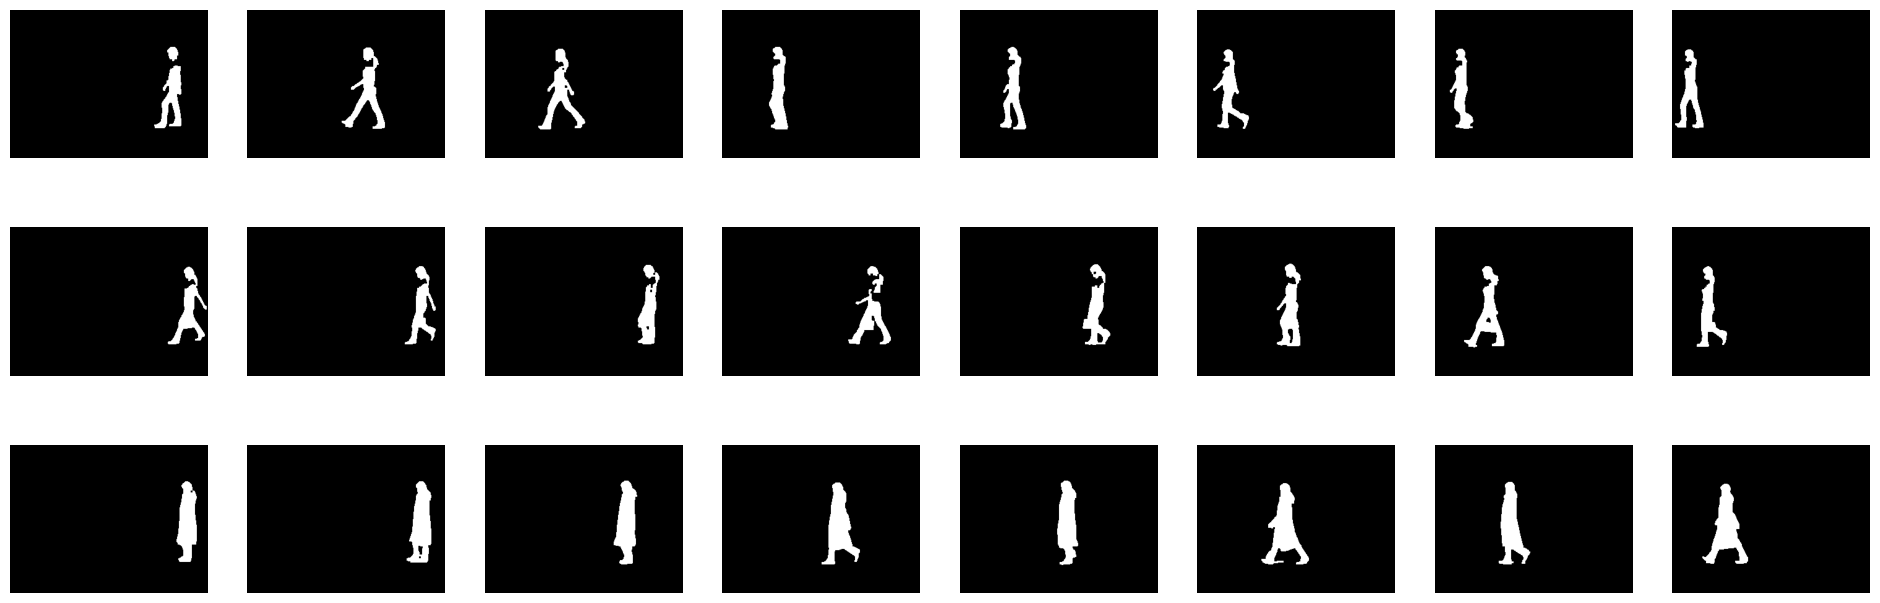

In [ ]:
print('Gait Energy Images of a person from 90: normal, holding a bag, wearing a coat\n')

people = os.listdir('processed_dataset')
random.shuffle(people)
person = people[0]

plt.rcParams['figure.figsize'] = (24, 8)
fig, ax = plt.subplots(3, 8)

styles = ['nm-01', 'bg-01', 'cl-01']

for i, style in enumerate(styles):
  folder = 'processed_dataset' + '/' + str(person) + '/' + 'gait' + '/' + style + '/' + '090'
  files = os.listdir(folder)
  random.shuffle(files)
  files = files[: 8]
  files.sort()

  for j, file in enumerate(files):
    path = folder + '/' + file
    image = cv2.imread(path)
    ax[i, j].imshow(image)
    ax[i, j].axis('off')

plt.show()

In [ ]:
from tqdm import tqdm
def get_dataset(num_people, faces, gait_styles):
  x1 = []
  x2 = []
  y  = []
  for i in tqdm(range(num_people)):

      for j in faces:
          path = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'face' + '/' + str(j+1) + '.pgm'
          image = cv2.imread(path, -1)
          image = cv2.resize(image, (12, 12))
          face = image.reshape(12, 12, 1)

          gait_folder = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'gait' + '/'

          for style in gait_styles:

              style_folder = gait_folder + style + '/'
              angles = os.listdir(style_folder)
              angles.sort()
              x = []
              for angle in angles:
                  angle_folder = style_folder + angle + '/'
                  images = os.listdir(angle_folder)
                  random.shuffle(images)
                  images = images[: 16]
                  images.sort()
                  xx = []
                  for image in images:
                      path = angle_folder + image
                      img = cv2.imread(path, -1)
                      img = cv2.resize(img, (32, 32))
                      img = np.array(img, dtype=np.float16)
                      xx.append(img)
                  xx = np.array(xx, dtype=np.float16)
                  x.append(xx)
              gait = np.stack(x, axis=3)

              x1.append(face)
              x2.append(gait)
              y.append(i)

  x1 = np.array(x1, dtype = np.float32)
  x2 = np.array(x2, dtype = np.float32)
  y = tf.keras.utils.to_categorical(y)
  x1, x2, y = shuffle(x1, x2, y)
  return x1, x2, y

In [ ]:
num_people = 40

faces = [0, 1, 2, 3, 4, 5, 6]
gait_styles = ['bg-01', 'cl-01', 'nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05' ]
x_face, x_gait, y = get_dataset(num_people, faces, gait_styles)

print('x_face:', x_face.shape)
print('x_gait:', x_gait.shape)
print('y     :', y.shape)

faces_val = [7, 8, 9]
gait_styles_val = ['bg-02', 'cl-02', 'nm-06']
x_face_val, x_gait_val, y_val = get_dataset(num_people, faces_val, gait_styles_val)

print('x_face_val:', x_face_val.shape)
print('x_gait_val:', x_gait_val.shape)
print('y_val     :', y_val.shape)

100%|██████████| 40/40 [01:22<00:00,  2.07s/it]


x_face: (1960, 12, 12, 1)
x_gait: (1960, 16, 32, 32, 11)
y     : (1960, 40)


100%|██████████| 40/40 [00:15<00:00,  2.65it/s]


x_face_val: (360, 12, 12, 1)
x_gait_val: (360, 16, 32, 32, 11)
y_val     : (360, 40)


In [ ]:
face_input = tf.keras.layers.Input(shape = (12, 12, 1), name = 'face_input')

face_encoder = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', name = 'face_conv_1')(face_input)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_1')(face_encoder)
face_encoder = tf.keras.layers.Flatten(name = 'face_flatten_1')(face_encoder)
face_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'face_dense_1')(face_encoder)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_2')(face_encoder)
face_encoder = tf.keras.layers.BatchNormalization(name = 'face_norm_1')(face_encoder)

gait_input = tf.keras.layers.Input(shape = (16, 32, 32, 11), name = 'gait_input')

gait_encoder = tf.keras.layers.ConvLSTM2D(16, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_1')(gait_input)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_1')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(8, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_2')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_2')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(1, kernel_size = 3, name = 'gait_convlstm_3')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_3')(gait_encoder)
gait_encoder = tf.keras.layers.Flatten(name = 'gait_flatten_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'gait_dense_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_4')(gait_encoder)
gait_encoder = tf.keras.layers.BatchNormalization(name = 'gait_norm_1')(gait_encoder)

def weighted_average(tensors):
  alpha = 0.5
  face = tensors[0]
  gait = tensors[1]
  weighted_average = alpha * face + (1 - alpha) * gait
  return weighted_average

decoder = tf.keras.layers.Lambda(weighted_average, name = 'face_gait_weighted_average')([face_encoder, gait_encoder])

decoder = tf.keras.layers.Dense(40, activation = 'softmax', name = 'output')(decoder)

model = tf.keras.models.Model(
      inputs = [face_input, gait_input],
      outputs = decoder)

model.compile(optimizer = tf.keras.optimizers.Firefly(),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gait_input (InputLayer)        [(None, 16, 32, 32,  0           []                               
                                 11)]                                                             
                                                                                                  
 gait_convlstm_1 (ConvLSTM2D)   (None, 16, 30, 30,   15616       ['gait_input[0][0]']             
                                16)                                                               
                                                                                                  
 gait_dropout_1 (Dropout)       (None, 16, 30, 30,   0           ['gait_convlstm_1[0][0]']        
                                16)                                                           

In [ ]:
EPOCHS = 10
BATCH_SIZE = 16

history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = EPOCHS,validation_data = ([x_face_val, x_gait_val], y_val), validation_batch_size = BATCH_SIZE)

Epoch 1/10
123/123 [==============================] - 60s 320ms/step - loss: 3.2003 - accuracy: 0.2046 - val_loss: 2.9615 - val_accuracy: 0.2444
Epoch 2/10
123/123 [==============================] - 37s 302ms/step - loss: 2.1424 - accuracy: 0.6342 - val_loss: 1.9801 - val_accuracy: 0.6389
Epoch 3/10
123/123 [==============================] - 38s 304ms/step - loss: 1.2353 - accuracy: 0.8974 - val_loss: 1.1275 - val_accuracy: 0.9472
Epoch 4/10
123/123 [==============================] - 38s 306ms/step - loss: 0.6474 - accuracy: 0.9750 - val_loss: 0.7273 - val_accuracy: 0.9528
Epoch 5/10
123/123 [==============================] - 38s 311ms/step - loss: 0.3767 - accuracy: 0.9903 - val_loss: 0.5286 - val_accuracy: 0.9667
Epoch 6/10
123/123 [==============================] - 37s 304ms/step - loss: 0.2363 - accuracy: 0.9980 - val_loss: 0.4233 - val_accuracy: 0.9583
Epoch 7/10
123/123 [==============================] - 38s 309ms/step - loss: 0.1729 - accuracy: 0.9959 - val_loss: 0.3491 - val_ac

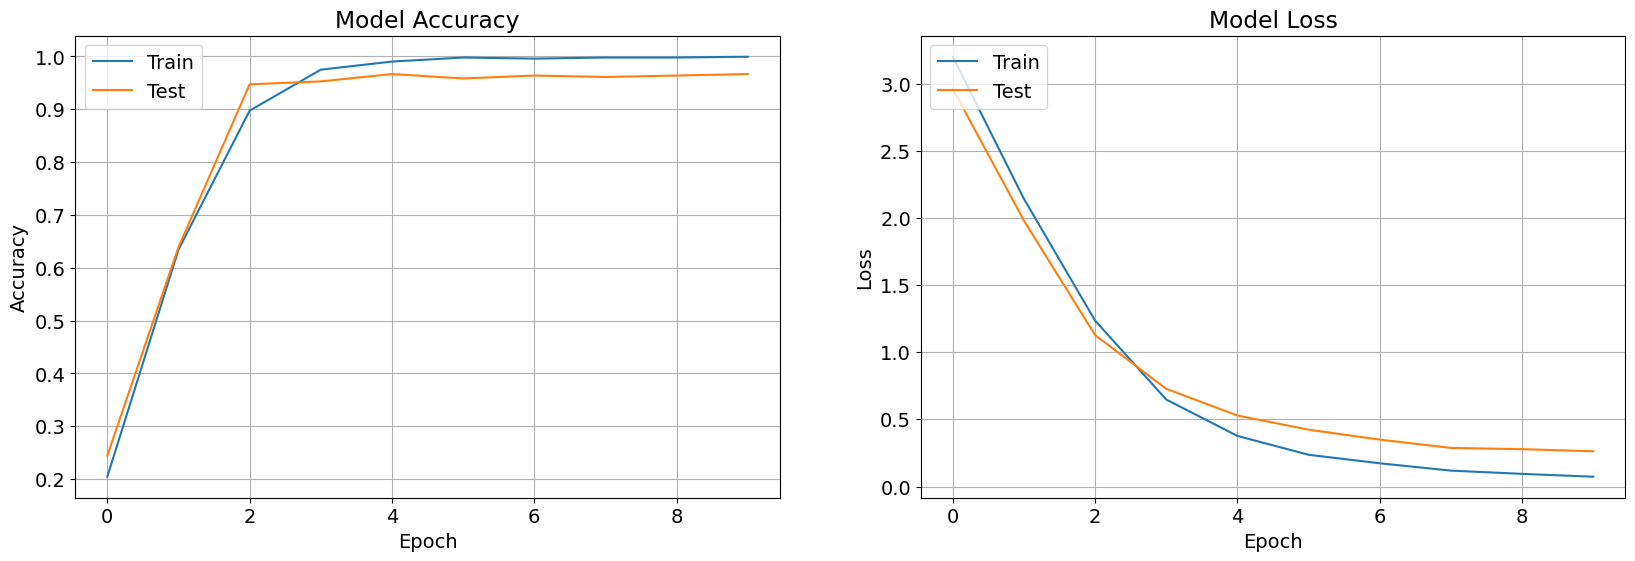

In [ ]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')
ax[0].grid()

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')
ax[1].grid()

plt.show()

In [ ]:
print('Total distinct people:', len(os.listdir('processed_dataset')))

Total distinct people: 40


Gait Energy Images of a person from 90: normal, holding a bag, wearing a coat



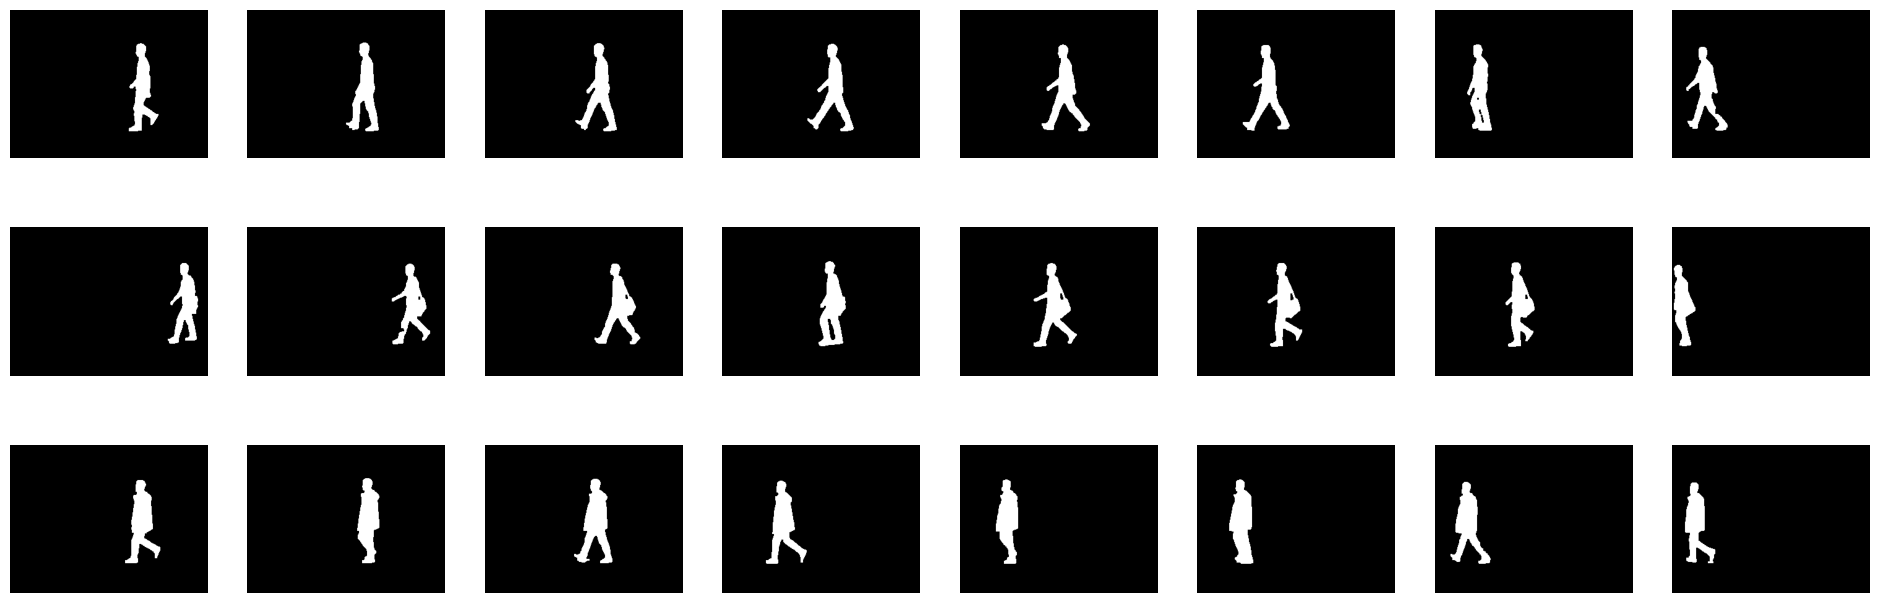

In [ ]:
print('Gait Energy Images of a person from 90: normal, holding a bag, wearing a coat\n')

people = os.listdir('processed_dataset')
random.shuffle(people)
person = people[0]

plt.rcParams['figure.figsize'] = (24, 8)
fig, ax = plt.subplots(3, 8)

styles = ['nm-01', 'bg-01', 'cl-01']

for i, style in enumerate(styles):
  folder = 'processed_dataset' + '/' + str(person) + '/' + 'gait' + '/' + style + '/' + '090'
  files = os.listdir(folder)
  random.shuffle(files)
  files = files[: 8]
  files.sort()

  for j, file in enumerate(files):
    path = folder + '/' + file
    image = cv2.imread(path)
    ax[i, j].imshow(image)
    ax[i, j].axis('off')

plt.show()

Using Fusion Model

In [ ]:
face_input = tf.keras.layers.Input(shape = (12, 12, 1), name = 'face_input')

face_encoder = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', name = 'face_conv_1')(face_input)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_1')(face_encoder)
face_encoder = tf.keras.layers.Flatten(name = 'face_flatten_1')(face_encoder)
face_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'face_dense_1')(face_encoder)
face_encoder = tf.keras.layers.Dropout(0.2, name = 'face_dropout_2')(face_encoder)
face_encoder = tf.keras.layers.BatchNormalization()(face_encoder)

gait_input = tf.keras.layers.Input(shape = (16, 32, 32, 11), name = 'gait_input')

gait_encoder = tf.keras.layers.ConvLSTM2D(16, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_1')(gait_input)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_1')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(8, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_2')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_2')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(1, kernel_size = 3, name = 'gait_convlstm_3')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_3')(gait_encoder)
gait_encoder = tf.keras.layers.Flatten(name = 'gait_flatten_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'gait_dense_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.4, name = 'gait_dropout_4')(gait_encoder)
gait_encoder = tf.keras.layers.BatchNormalization()(gait_encoder)

def weighted_average(tensors):
  alpha = 0.5
  face = tensors[0]
  gait = tensors[1]
  weighted_average = alpha * face + (1 - alpha) * gait
  return weighted_average

decoder = tf.keras.layers.Lambda(weighted_average, name = 'face_gait_weighted_average')([face_encoder, gait_encoder])

decoder = tf.keras.layers.Dense(40, activation = 'softmax', name = 'output')(decoder)

model = tf.keras.models.Model(
      inputs = [face_input, gait_input],
      outputs = decoder)

model.compile(optimizer = tf.keras.optimizers.Firefly(learning_rate = 0.0003),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gait_input (InputLayer)        [(None, 16, 32, 32,  0           []                               
                                 11)]                                                             
                                                                                                  
 gait_convlstm_1 (ConvLSTM2D)   (None, 16, 30, 30,   15616       ['gait_input[0][0]']             
                                16)                                                               
                                                                                                  
 gait_dropout_1 (Dropout)       (None, 16, 30, 30,   0           ['gait_convlstm_1[0][0]']        
                                16)                                                         

In [ ]:
EPOCHS = 60
BATCH_SIZE = 4
VALID_SPLIT = 0.3

acc_train = []
acc_val = []

In [ ]:
history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VALID_SPLIT)
acc_train += history.history['accuracy']
acc_val += history.history['val_accuracy']

Epoch 1/60
343/343 [==============================] - 54s 135ms/step - loss: 3.6557 - accuracy: 0.0605 - val_loss: 3.4055 - val_accuracy: 0.1020
Epoch 2/60
343/343 [==============================] - 45s 130ms/step - loss: 3.3870 - accuracy: 0.1159 - val_loss: 2.9556 - val_accuracy: 0.3776
Epoch 3/60
343/343 [==============================] - 45s 132ms/step - loss: 3.1782 - accuracy: 0.1953 - val_loss: 2.6635 - val_accuracy: 0.5051
Epoch 4/60
343/343 [==============================] - 45s 133ms/step - loss: 2.9878 - accuracy: 0.2726 - val_loss: 2.4726 - val_accuracy: 0.5680
Epoch 5/60
343/343 [==============================] - 44s 129ms/step - loss: 2.7303 - accuracy: 0.3914 - val_loss: 1.9733 - val_accuracy: 0.7602
Epoch 6/60
343/343 [==============================] - 55s 159ms/step - loss: 2.5032 - accuracy: 0.4840 - val_loss: 1.7404 - val_accuracy: 0.8180
Epoch 7/60
343/343 [==============================] - 44s 128ms/step - loss: 2.2530 - accuracy: 0.5539 - val_loss: 1.3452 - val_ac

Gait Energy Images of a person from 90: normal, holding a bag, wearing a coat



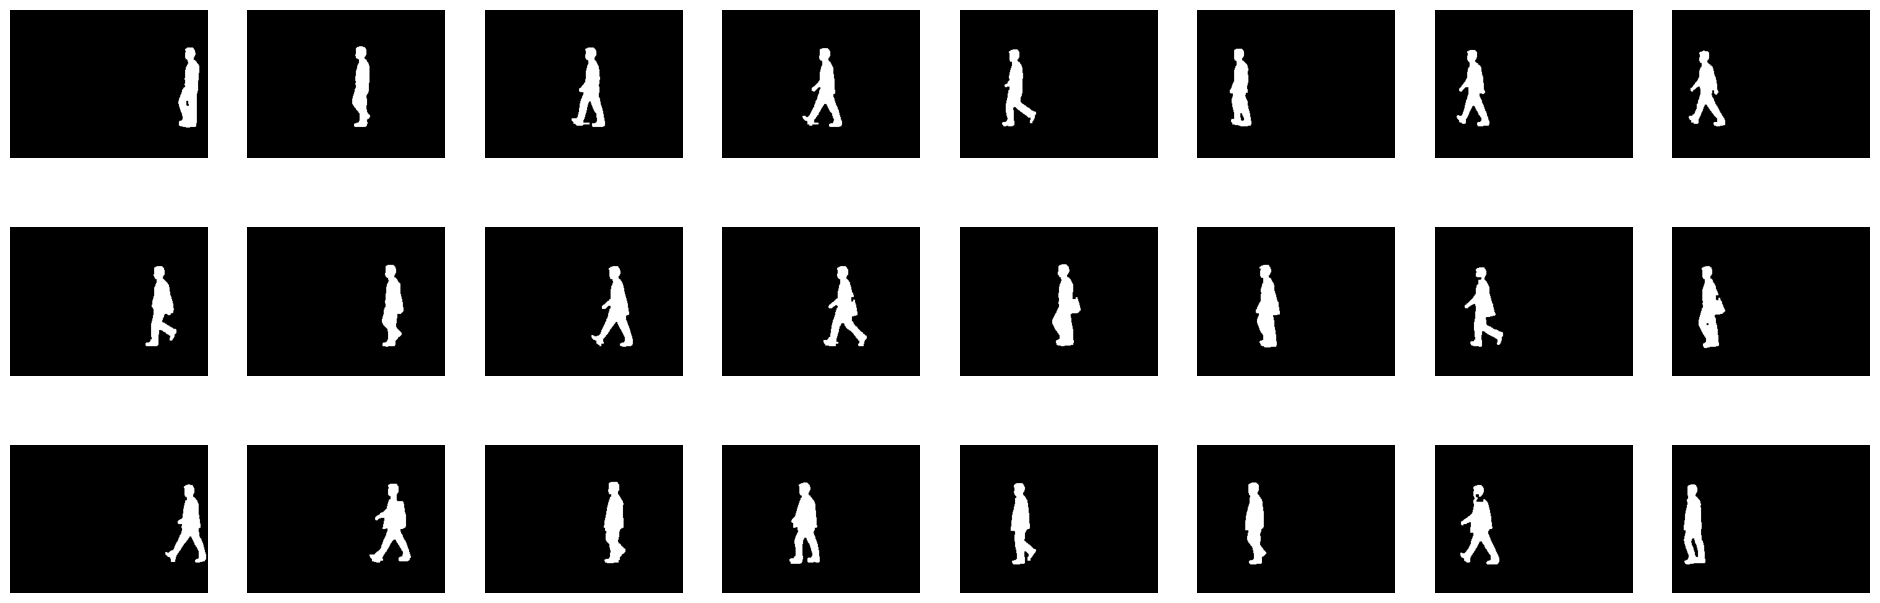

In [ ]:
print('Gait Energy Images of a person from 90: normal, holding a bag, wearing a coat\n')

people = os.listdir('processed_dataset')
random.shuffle(people)
person = people[0]

plt.rcParams['figure.figsize'] = (24, 8)
fig, ax = plt.subplots(3, 8)

styles = ['nm-01', 'bg-01', 'cl-01']

for i, style in enumerate(styles):
  folder = 'processed_dataset' + '/' + str(person) + '/' + 'gait' + '/' + style + '/' + '090'
  files = os.listdir(folder)
  random.shuffle(files)
  files = files[: 8]
  files.sort()

  for j, file in enumerate(files):
    path = folder + '/' + file
    image = cv2.imread(path)
    ax[i, j].imshow(image)
    ax[i, j].axis('off')

plt.show()

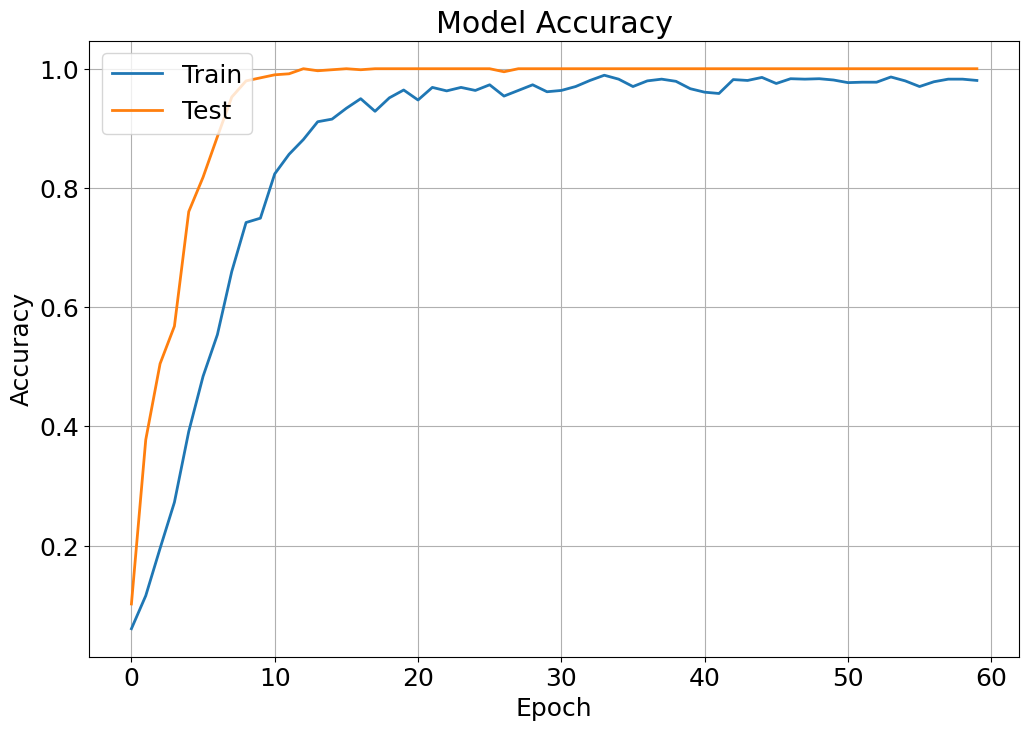

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 18

plt.plot(acc_train, linewidth=2)
plt.plot(acc_val, linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

In [ ]:
import tensorflow as tf

# Assuming you have a trained model
model = model

# Assuming you have x_face_val, x_gait_val, and y_val from the previous code
# x_face_val has shape (num_samples, 12, 12)
# x_gait_val has shape (num_samples, num_gait_styles, 16, 32, 32, 11)
# y_val has shape (num_samples, num_classes)

# Preprocess the validation data (assuming you have normalized it as in the previous code)
x_face_val_processed = x_face_val.astype('float32') / 255.0
x_gait_val_processed = x_gait_val.astype('float32') / 255.0
x_gait_val_processed = tf.expand_dims(x_gait_val_processed, axis=-1)  # Add channel dimension for ConvLSTM

# Make predictions on the validation data
predictions_val = model.predict([x_face_val_processed, x_gait_val_processed])

# Get the predicted classes
predicted_classes_val = tf.argmax(predictions_val, axis=1)

# Calculate the accuracy on the validation data
accuracy_val = tf.reduce_mean(tf.cast(tf.equal(predicted_classes_val, tf.argmax(y_val, axis=1)), tf.float32))

# Print the accuracy
print(f'Validation Accuracy: {accuracy_val.numpy()}')

12/12 [==============================] - 3s 59ms/step
Validation Accuracy: 0.16111111640930176
